# **Judul: Trend Analysis Mobil Asia dan Prediksi Engagement**

Catatan:
*   Analisis trend merek mobil Asia mulai dari jumlah tweets, like, dan quotes dalam periode waktu tertentu;
*   Prediksi Engagement menggunakan menggunakan LSTM;
*   Variabel "Engagement" didapatkan dari total jumlah tweet, like, dan quote;
*   Data twitter yang membahas mobil Eropa tidak digunakan dan tidak dimasukkan ke dalam model karena jumlah datanya terlalu sedikit.



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## **Data Understanding**

In [2]:
#Import Dataset dari GitHub
!mkdir Data
!wget -P Data/ https://raw.githubusercontent.com/syahrulazka/deep-learning/main/tweets-bm.csv.csv
df = pd.read_csv("https://raw.githubusercontent.com/syahrulazka/deep-learning/main/tweets-bm.csv.csv", low_memory=False, encoding='utf8')
df.head()

--2024-07-20 19:02:29--  https://raw.githubusercontent.com/syahrulazka/deep-learning/main/tweets-bm.csv.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 890374 (870K) [text/plain]
Saving to: ‘Data/tweets-bm.csv.csv’

tweets-bm.csv.csv   100%[===================>] 869.51K  --.-KB/s    in 0.008s  

2024-07-20 19:02:29 (109 MB/s) - ‘Data/tweets-bm.csv.csv’ saved [890374/890374]



,id_,created_at,tweetID,tweet,username,id_str,name,entity,likes,retweets,quotes,replies,sentiment,bidang,gender,link,imageUrl
0,1,2023-01-01 13:50:44,1.609548e+18,"Hallo, sobat Nedutase Lepas Sambut Kepala SMK ...",TangselSmkn2,1414792059257380864,SMKN2Tangsel,Daihatsu,NaN,NaN,NaN,1,Netral,NaN,NaN,https://twitter.com/TangselSmkn2,https://pbs.twimg.com/profile_images/155974970...
1,2,2023-01-01 11:00:01,1.609505e+18,Shin Tae-yong selaku pelatih kepala Timnas Ind...,PSSI,2363027508,PSSI,Mitsubishi,1837302.0,159.0,24686.0,31,Netral,NaN,NaN,https://twitter.com/PSSI/status/16095047120127...,https://pbs.twimg.com/media/FlYVvBCaUAA-LHy.jp...
2,3,2023-01-02 9:41:59,1.609847e+18,SUZUKI XL 7 Jawabannya! Tampilan eksterior Suz...,GampongSuzuki,971377286,Gampong Suzuki,Suzuki,140.0,72.0,1510.0,0,Positif,NaN,NaN,https://twitter.com/GampongSuzuki/status/16098...,https://pbs.twimg.com/media/FldTuxJakAQTrqR.jp...
3,4,2023-01-03 7:19:49,1.610174e+18,Baru saja mengirim foto @ TOYOTA PERINTIS GATS...,toyotamedan_id,732457105,Toyota Medan 082167506001,Toyota,642.0,1.0,757.0,0,Netral,NaN,NaN,https://twitter.com/toyotamedan_id/status/1610...,https://pbs.twimg.com/profile_images/147098860...
4,5,2023-01-03 2:29:01,1.610101e+18,DIJUAL BMW E30 318i Mesin M10 Plat R Pajak On ...,HoldenKlasik,1391235014,Suka Mobil Tua,BMW,154655.0,402.0,96590.0,1,Netral,NaN,NaN,https://twitter.com/HoldenKlasik/status/161010...,https://pbs.twimg.com/media/Flg6NOsaUAAS5FA.jp...


In [3]:
df.columns

Index(['id_', 'created_at', 'tweetID', 'tweet', 'username', 'id_str', 'name',
       'entity', 'likes', 'retweets', 'quotes', 'replies', 'sentiment',
       'bidang', 'gender', 'link', 'imageUrl'],
      dtype='object')

In [4]:
df = pd.DataFrame(df[['created_at','entity','likes','retweets','quotes','replies']])

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2124 entries, 0 to 2123
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   created_at  2124 non-null   object 
 1   entity      2124 non-null   object 
 2   likes       1602 non-null   float64
 3   retweets    1602 non-null   float64
 4   quotes      1602 non-null   float64
 5   replies     2124 non-null   int64  
dtypes: float64(3), int64(1), object(2)
memory usage: 99.7+ KB


In [6]:
df.value_counts('entity')

entity
Daihatsu      463
Toyota        457
Suzuki        324
Honda         287
Mitsubishi    232
Wuling        190
Hyundai       145
BMW            11
AUDI            9
Mazda           5
Mercedez        1
Name: count, dtype: int64

##  **Data Cleansing**

In [7]:
df.dropna(inplace=True)
df.drop_duplicates(inplace=True)

In [8]:
df.shape

(1602, 6)

## **Feature Engeneering**

In [9]:
df['created_at'] = pd.to_datetime(df['created_at'])
df['date'] = df['created_at'].dt.date
df = df.drop('created_at', axis=1)
df['engagement'] = df['likes'] + df['retweets'] + df['quotes'] + df['replies']

In [10]:
df.head()

,entity,likes,retweets,quotes,replies,date,engagement
1,Mitsubishi,1837302.0,159.0,24686.0,31,2023-01-01,1862178.0
2,Suzuki,140.0,72.0,1510.0,0,2023-01-02,1722.0
3,Toyota,642.0,1.0,757.0,0,2023-01-03,1400.0
4,BMW,154655.0,402.0,96590.0,1,2023-01-03,251648.0
5,Mitsubishi,7627.0,30.0,5000.0,6,2023-01-03,12663.0


In [11]:
df = df[['date', 'entity',	'likes', 'retweets', 'quotes', 'replies', 'engagement']]
df.head()

,date,entity,likes,retweets,quotes,replies,engagement
1,2023-01-01,Mitsubishi,1837302.0,159.0,24686.0,31,1862178.0
2,2023-01-02,Suzuki,140.0,72.0,1510.0,0,1722.0
3,2023-01-03,Toyota,642.0,1.0,757.0,0,1400.0
4,2023-01-03,BMW,154655.0,402.0,96590.0,1,251648.0
5,2023-01-03,Mitsubishi,7627.0,30.0,5000.0,6,12663.0


In [12]:
df['date'] = pd.to_datetime(df['date'])

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1602 entries, 1 to 2123
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        1602 non-null   datetime64[ns]
 1   entity      1602 non-null   object        
 2   likes       1602 non-null   float64       
 3   retweets    1602 non-null   float64       
 4   quotes      1602 non-null   float64       
 5   replies     1602 non-null   int64         
 6   engagement  1602 non-null   float64       
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 164.7+ KB


In [14]:
origins = {
    'Toyota': 'Asia',
    'Daihatsu': 'Asia',
    'Suzuki': 'Asia',
    'Honda': 'Asia',
    'Mitsubishi': 'Asia',
    'Wuling': 'Asia',
    'Hyundai': 'Asia',
    'BMW': 'Europe',
    'Mazda': 'Asia',
    'AUDI': 'Europe',
    'Mercedez': 'Europe'
}

df['brand origin'] = df['entity'].map(origins)

In [15]:
df = pd.DataFrame(df[['date', 'entity', 'brand origin', 'likes', 'retweets', 'quotes', 'replies',
       'engagement']])

In [16]:
df

,date,entity,brand origin,likes,retweets,quotes,replies,engagement
1,2023-01-01,Mitsubishi,Asia,1837302.0,159.0,24686.0,31,1862178.0
2,2023-01-02,Suzuki,Asia,140.0,72.0,1510.0,0,1722.0
3,2023-01-03,Toyota,Asia,642.0,1.0,757.0,0,1400.0
4,2023-01-03,BMW,Europe,154655.0,402.0,96590.0,1,251648.0
5,2023-01-03,Mitsubishi,Asia,7627.0,30.0,5000.0,6,12663.0
...,...,...,...,...,...,...,...,...
2118,2024-04-29,Honda,Asia,366226.0,52.0,100504.0,0,466782.0
2119,2024-04-30,Honda,Asia,14970.0,2962.0,12081.0,66,30079.0
2120,2024-04-29,Honda,Asia,1078416.0,3.0,1073489.0,0,2151908.0
2121,2024-04-30,Honda,Asia,1461997.0,537.0,909505.0,2,2372041.0


## **Data Visualization**

## Bagaimana perbandingan engagement yang membahas tentang mobil Asia dan mobil Eropa?

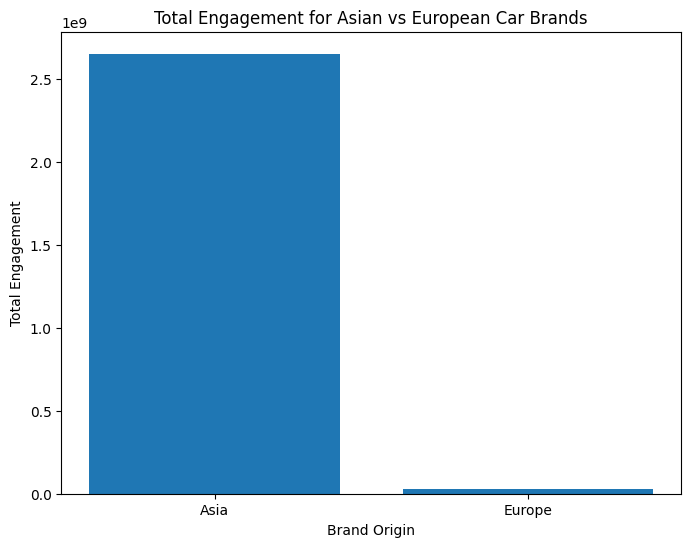

In [17]:
# Group by brand origin and sum engagement
grouped_origin = df.groupby('brand origin')['engagement'].sum().reset_index()
# Create a bar chart
plt.figure(figsize=(8, 6))
plt.bar(grouped_origin['brand origin'], grouped_origin['engagement'])
plt.title('Total Engagement for Asian vs European Car Brands')
plt.xlabel('Brand Origin')
plt.ylabel('Total Engagement')
plt.show()

## Bagaimana perbandingan Likes, retweets, quotes, dan repllies untuk setiap merk mobil dari asia?

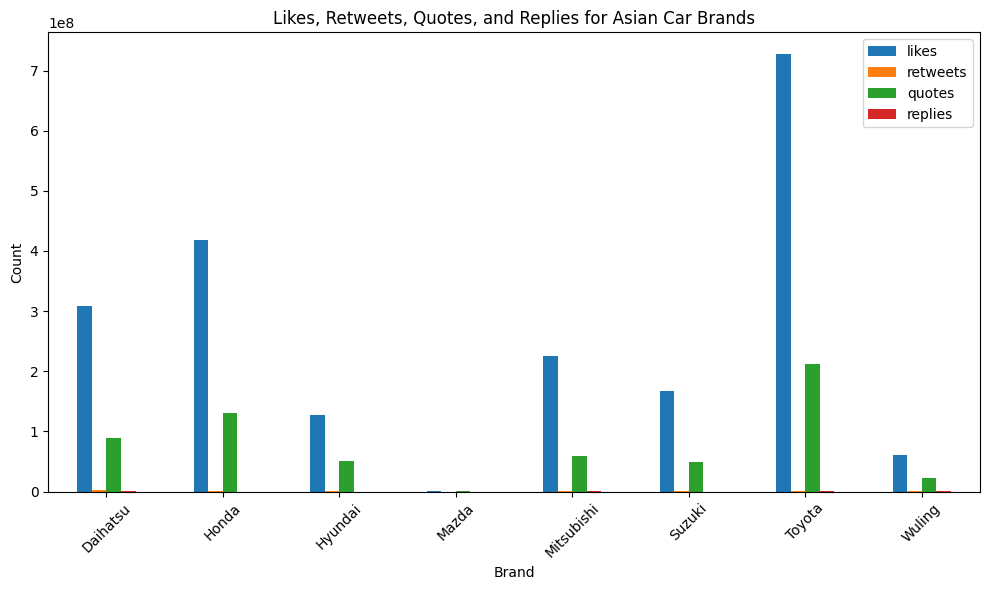

In [18]:
asia_df = df[df['brand origin'] == 'Asia']
grouped_asia = asia_df.groupby('entity')[['likes', 'retweets', 'quotes','replies']].sum().reset_index()
grouped_asia.plot(x='entity', y=['likes', 'retweets', 'quotes', 'replies'], kind='bar', figsize=(10, 6))
plt.title('Likes, Retweets, Quotes, and Replies for Asian Car Brands')
plt.xlabel('Brand')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Bagaimana perbandingan persentase antara likes, retweets, quotes, replies, engagement untuk setiap merk mobil asia?

In [19]:
# Group the DataFrame by brand and sum the engagement metrics
grouped_asia = asia_df.groupby('entity')[['likes', 'retweets', 'quotes', 'replies', 'engagement']].sum().reset_index()

# Calculate percentages for each metric
grouped_asia['likes_pct'] = grouped_asia['likes'] / grouped_asia['engagement'] * 100
grouped_asia['retweets_pct'] = grouped_asia['retweets'] / grouped_asia['engagement'] * 100
grouped_asia['quotes_pct'] = grouped_asia['quotes'] / grouped_asia['engagement'] * 100
grouped_asia['replies_pct'] = grouped_asia['replies'] / grouped_asia['engagement'] * 100

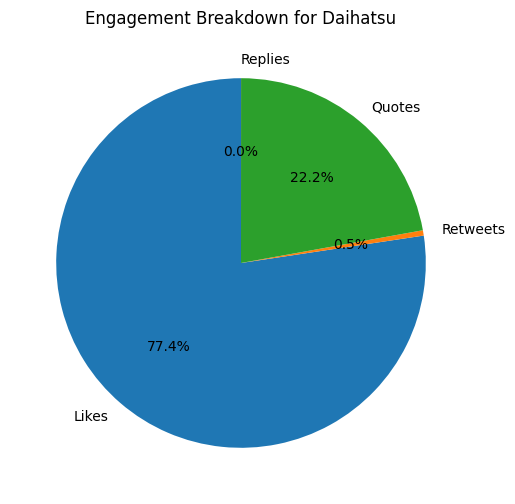

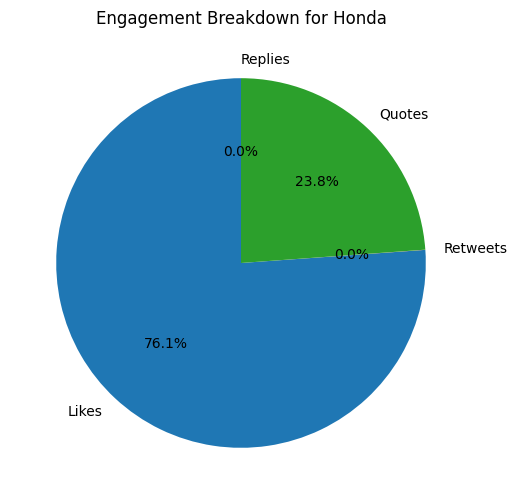

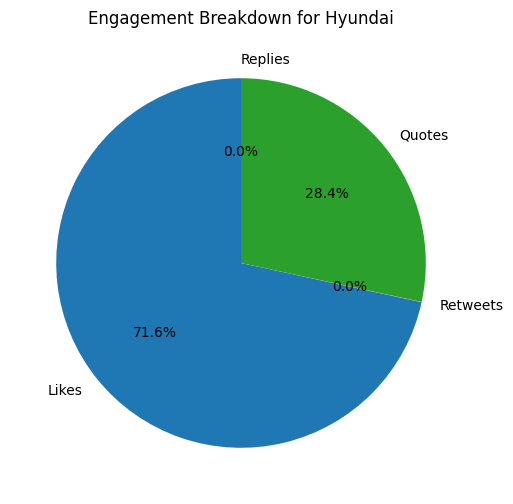

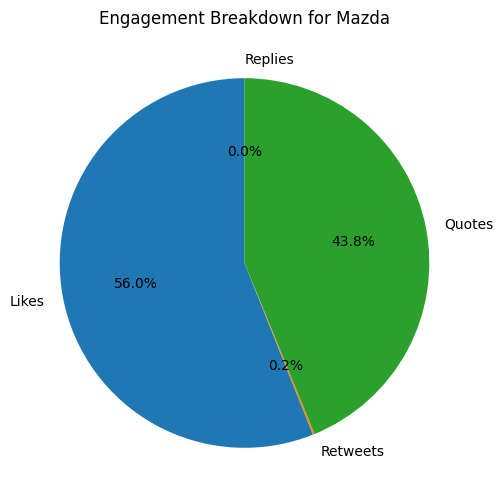

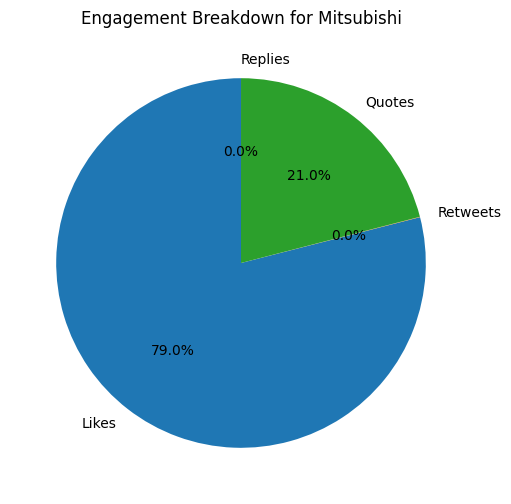

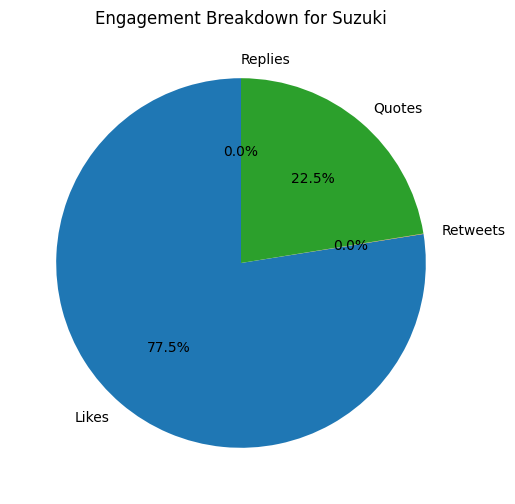

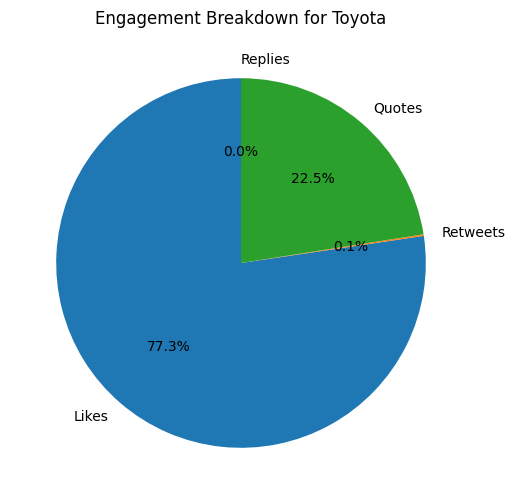

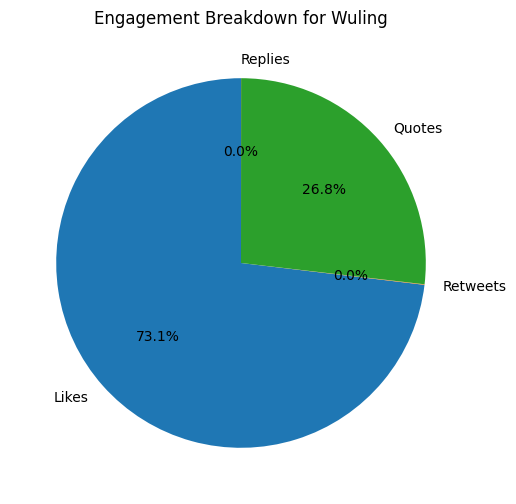

In [20]:
# Create a pie chart for each brand
for brand in grouped_asia['entity']:
    brand_data = grouped_asia[grouped_asia['entity'] == brand]
    labels = ['Likes', 'Retweets', 'Quotes', 'Replies']
    sizes = [brand_data['likes_pct'].values[0], brand_data['retweets_pct'].values[0], brand_data['quotes_pct'].values[0], brand_data['replies_pct'].values[0]]
    colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99']

    plt.figure(figsize=(6, 6))
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
    plt.title(f'Engagement Breakdown for {brand}')
    plt.show()

* Apakah ada pola trend tertentu pada setiap merk mobil Asia?
* Apakah pola trend untuk setiap merk mobil berbeda?

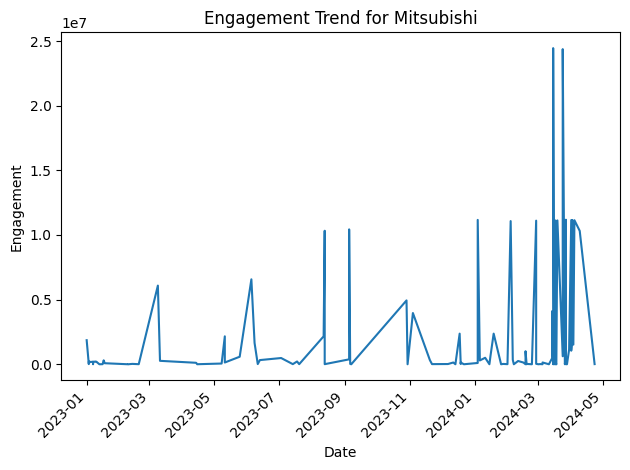

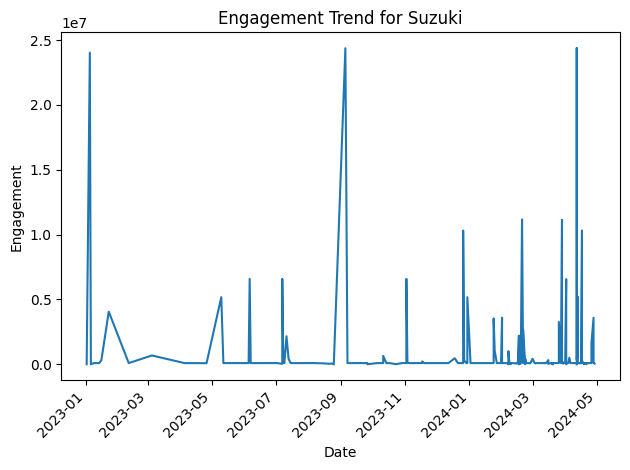

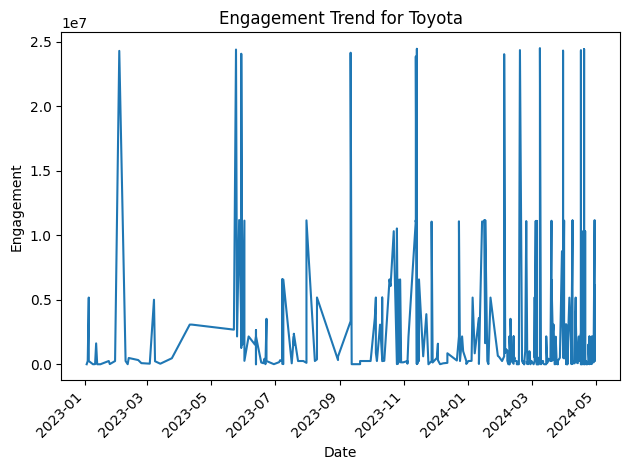

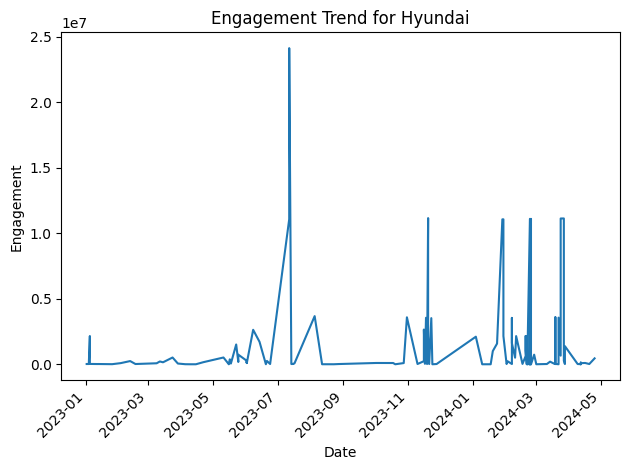

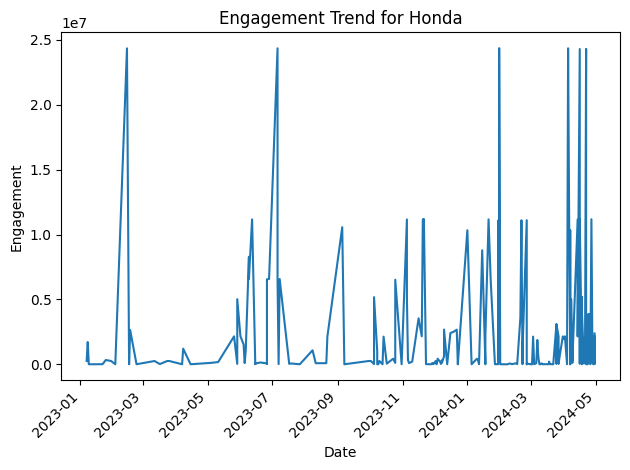

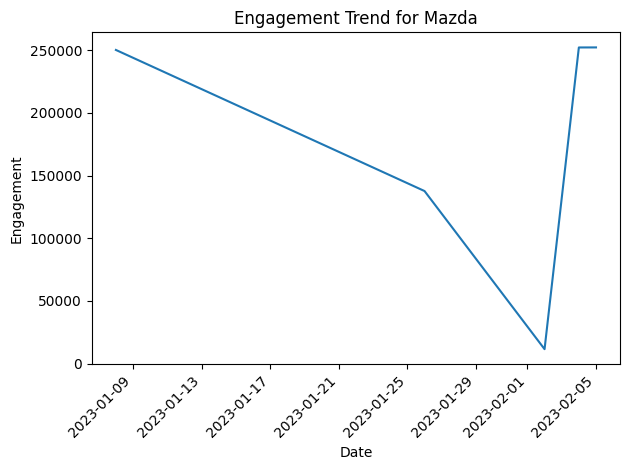

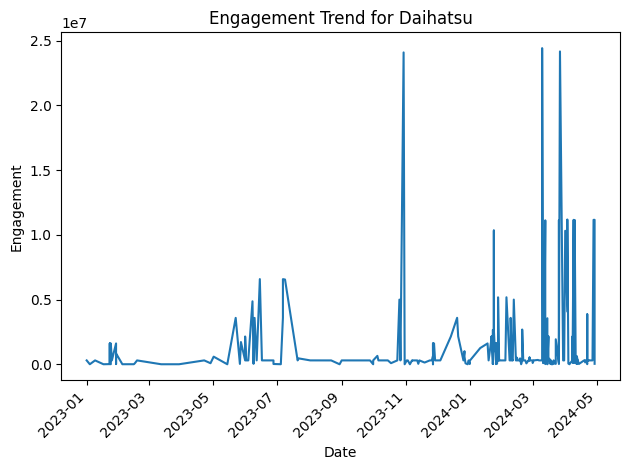

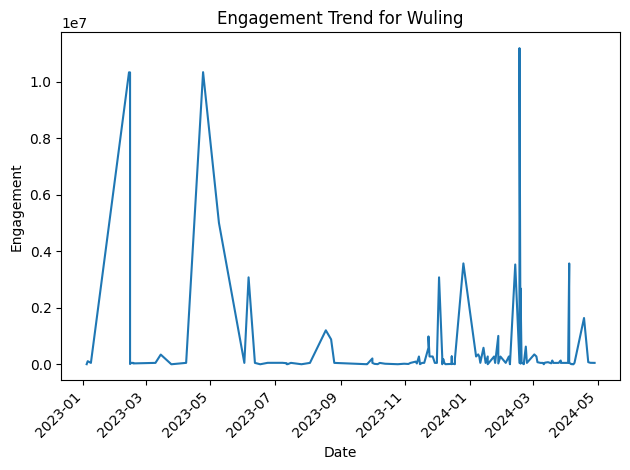

In [21]:
for entity in asia_df['entity'].unique():
    entity_df = asia_df[asia_df['entity'] == entity].sort_values('date') # Sort by date for proper trend visualization
    plt.figure()  # Create a new figure for each entity
    plt.plot(entity_df['date'], entity_df['engagement'])
    plt.xlabel('Date')
    plt.ylabel('Engagement')
    plt.title(f'Engagement Trend for {entity}')
    plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability if needed
    plt.tight_layout()  # Adjust layout to prevent labels from overlapping
    plt.show()

## Jumlah tweets setiap harinya untuk setiap brand mobil

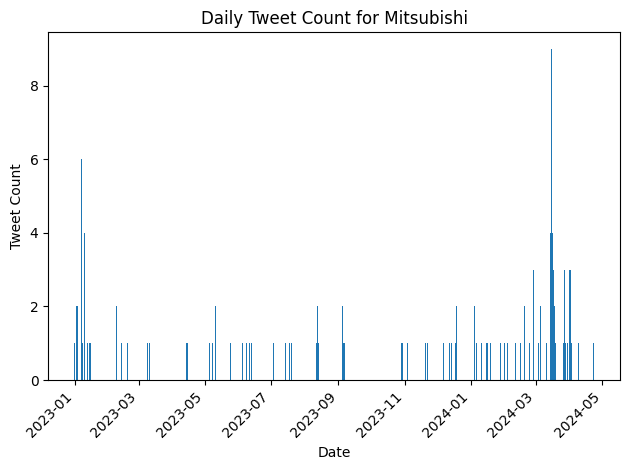

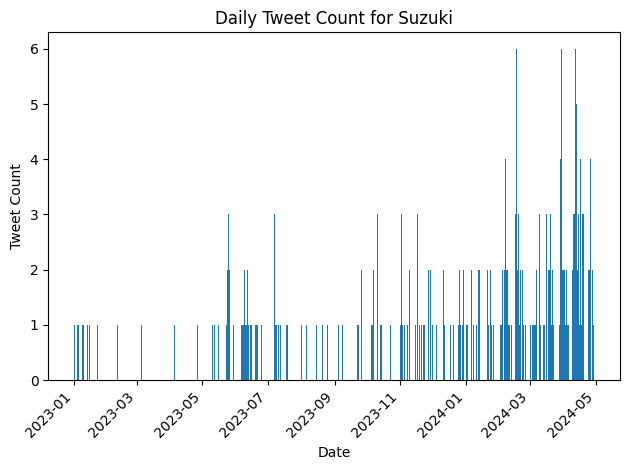

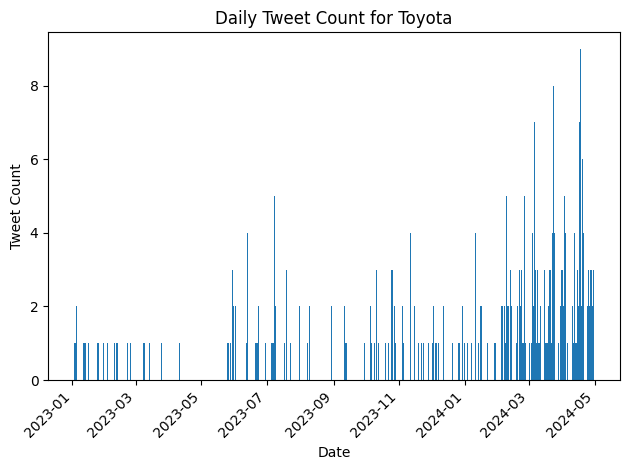

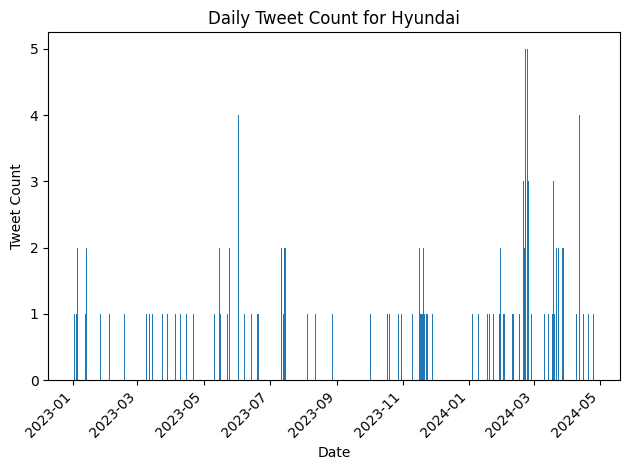

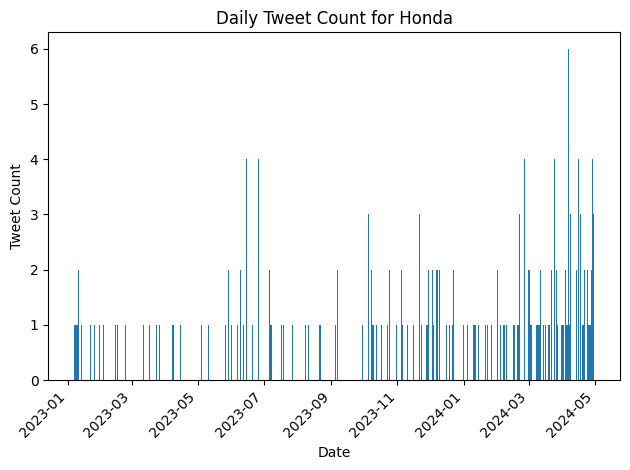

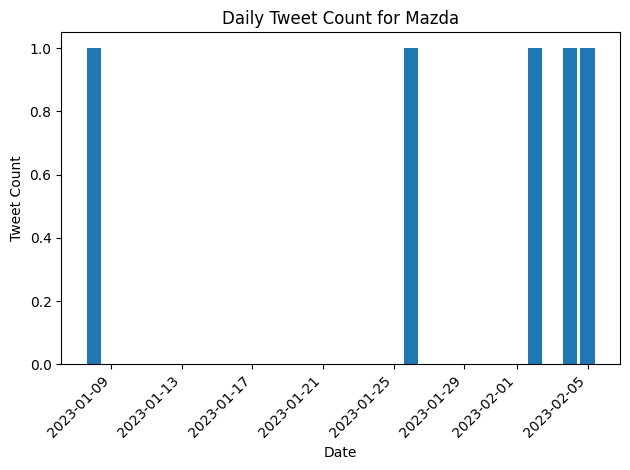

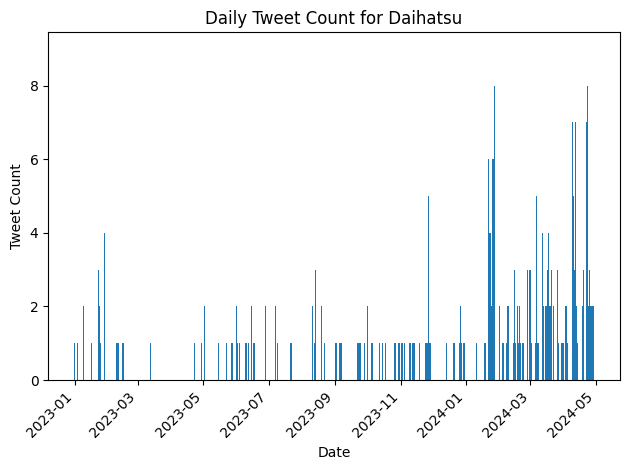

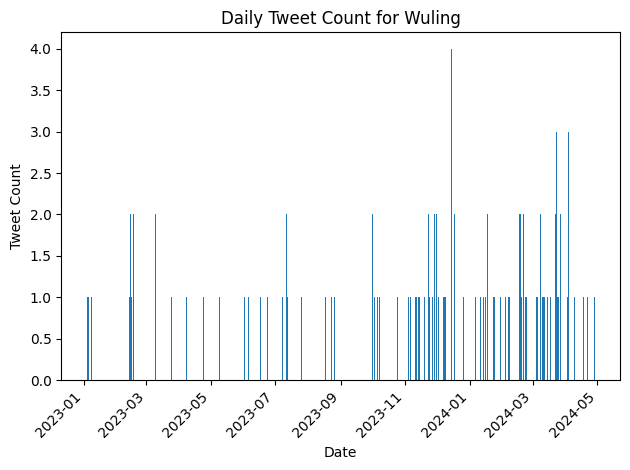

In [22]:
# Group by date and entity, count tweets
daily_tweets = asia_df.groupby(['date', 'entity'])['entity'].count().reset_index(name='tweet_count')

# Plot for each entity separately using bar chart
for entity in asia_df['entity'].unique():
    entity_df = daily_tweets[daily_tweets['entity'] == entity]
    plt.figure()
    plt.bar(entity_df['date'], entity_df['tweet_count'])
    plt.xlabel('Date')
    plt.ylabel('Tweet Count')
    plt.title(f'Daily Tweet Count for {entity}')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

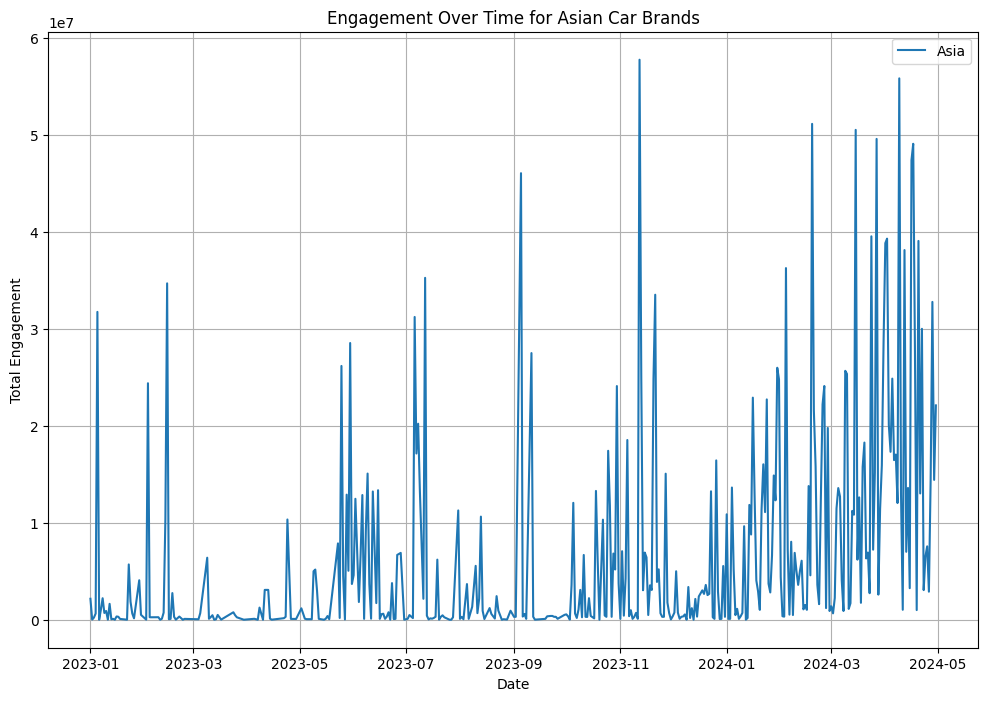

In [23]:
# Group the Asia DataFrame by date and sum the engagement
grouped_asia = asia_df.groupby('date')['engagement'].sum().reset_index()

# Create a line plot for engagement over time for Asia
plt.figure(figsize=(12, 8))
plt.plot(grouped_asia['date'], grouped_asia['engagement'], label='Asia') # Corrected line
plt.title('Engagement Over Time for Asian Car Brands')
plt.xlabel('Date')
plt.ylabel('Total Engagement')
plt.legend()
plt.grid(True)
plt.show()

# **Model LSTM untuk Prediksi Engagement**

In [24]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim

In [25]:
asia_df

,date,entity,brand origin,likes,retweets,quotes,replies,engagement
1,2023-01-01,Mitsubishi,Asia,1837302.0,159.0,24686.0,31,1862178.0
2,2023-01-02,Suzuki,Asia,140.0,72.0,1510.0,0,1722.0
3,2023-01-03,Toyota,Asia,642.0,1.0,757.0,0,1400.0
5,2023-01-03,Mitsubishi,Asia,7627.0,30.0,5000.0,6,12663.0
6,2023-01-03,Mitsubishi,Asia,183527.0,63.0,18353.0,9,201952.0
...,...,...,...,...,...,...,...,...
2118,2024-04-29,Honda,Asia,366226.0,52.0,100504.0,0,466782.0
2119,2024-04-30,Honda,Asia,14970.0,2962.0,12081.0,66,30079.0
2120,2024-04-29,Honda,Asia,1078416.0,3.0,1073489.0,0,2151908.0
2121,2024-04-30,Honda,Asia,1461997.0,537.0,909505.0,2,2372041.0


In [26]:
data = asia_df[['date','engagement']]
data = data.groupby('date')['engagement'].sum().reset_index()
data

,date,engagement
0,2023-01-01,2161549.0
1,2023-01-02,21453.0
2,2023-01-03,216015.0
3,2023-01-04,640993.0
4,2023-01-05,31742231.0
...,...,...
388,2024-04-26,2891111.0
389,2024-04-27,14470122.0
390,2024-04-28,32770374.0
391,2024-04-29,14419883.0


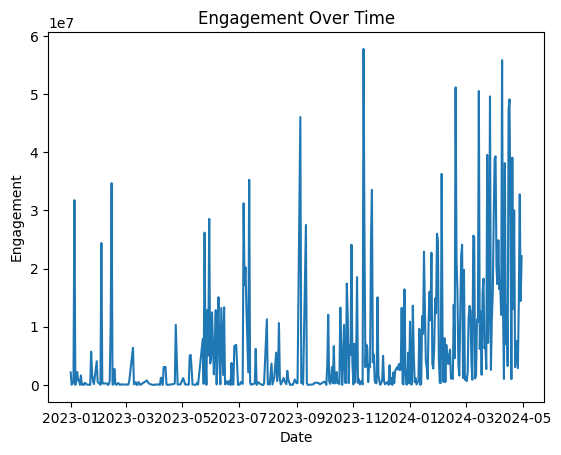

In [27]:
data['date'] = pd.to_datetime(data['date'])

plt.plot(data['date'], data['engagement'])
plt.xlabel('Date')
plt.ylabel('Engagement')
plt.title('Engagement Over Time')
plt.show()

In [28]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [29]:
# Set seed for reproducibility
seed = 1507
torch.manual_seed(seed)
np.random.seed(seed)

# Feature Scaling
scaler = MinMaxScaler()
data['engagement'] = scaler.fit_transform(data[['engagement']])

# Prepare sequences
def create_sequences(data, seq_length):
    sequences = []
    targets = []
    for i in range(len(data) - seq_length):
        seq = data[i:i+seq_length]
        target = data[i+seq_length]
        sequences.append(seq)
        targets.append(target)
    return np.array(sequences), np.array(targets)

seq_length = 5
data_seq, data_target = create_sequences(data['engagement'].values, seq_length)

# Split data into train and test sets
train_seq, test_seq, train_target, test_target = train_test_split(data_seq, data_target, test_size=0.2, random_state=seed)

# Convert to PyTorch tensors
train_seq = torch.tensor(train_seq, dtype=torch.float32)
train_target = torch.tensor(train_target, dtype=torch.float32)
test_seq = torch.tensor(test_seq, dtype=torch.float32)
test_target = torch.tensor(test_target, dtype=torch.float32)

In [30]:
# Define the more complex LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_layer_size, output_size, num_layers=2):
        super(LSTMModel, self).__init__()
        self.hidden_layer_size = hidden_layer_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_layer_size, num_layers, dropout=0.2)
        self.linear = nn.Linear(hidden_layer_size, output_size)
        self.hidden_cell = (torch.zeros(self.num_layers, 1, self.hidden_layer_size),
                            torch.zeros(self.num_layers, 1, self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq), 1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

# Model parameters
input_size = 1
hidden_layer_size = 512
output_size = 1
num_layers = 8

model = LSTMModel(input_size, hidden_layer_size, output_size)

# Define loss function and optimizer
loss_function = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [31]:
# Train the model
epochs = 25
model.train()
for i in range(epochs):
    for seq, labels in zip(train_seq, train_target):
        optimizer.zero_grad()
        # Initialize hidden cell with the correct number of layers
        model.hidden_cell = (torch.zeros(model.num_layers, 1, model.hidden_layer_size),
                        torch.zeros(model.num_layers, 1, model.hidden_layer_size))

        y_pred = model(seq)

        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()

    if i % 1 == 0:
        print(f'Epoch {i+1} loss: {single_loss.item()}')

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1 loss: 0.010915699414908886
Epoch 2 loss: 0.01604681834578514
Epoch 3 loss: 0.02060144580900669
Epoch 4 loss: 0.020319897681474686
Epoch 5 loss: 0.02092980407178402
Epoch 6 loss: 0.017143048346042633
Epoch 7 loss: 0.01332438737154007
Epoch 8 loss: 0.0131476866081357
Epoch 9 loss: 0.009833364747464657
Epoch 10 loss: 0.011131585575640202
Epoch 11 loss: 0.012175753712654114
Epoch 12 loss: 0.012711680494248867
Epoch 13 loss: 0.012658512219786644
Epoch 14 loss: 0.01163009274750948
Epoch 15 loss: 0.012366329319775105
Epoch 16 loss: 0.012235484085977077
Epoch 17 loss: 0.011338707990944386
Epoch 18 loss: 0.011705524288117886
Epoch 19 loss: 0.011389590799808502
Epoch 20 loss: 0.01247460301965475
Epoch 21 loss: 0.010746566578745842
Epoch 22 loss: 0.010312562808394432
Epoch 23 loss: 0.010022550821304321
Epoch 24 loss: 0.010687845759093761
Epoch 25 loss: 0.011030267924070358


In [33]:
# Evaluate the model
model.eval()
test_preds = []
with torch.no_grad():
    for seq in test_seq:
        # Initialize hidden cell with the correct number of layers
        model.hidden_cell = (torch.zeros(model.num_layers, 1, model.hidden_layer_size),
                        torch.zeros(model.num_layers, 1, model.hidden_layer_size))
        test_preds.append(model(seq).item())  # Get prediction and convert to a number

# Calculate MSE
test_preds = np.array(test_preds)
# Convert test_target to a NumPy array
test_target = test_target.numpy()  # Convert to NumPy for compatibility
mse = np.mean((test_preds - test_target)**2)
print(f'Test MSE: {mse}')

Test MSE: 0.029427530360678095


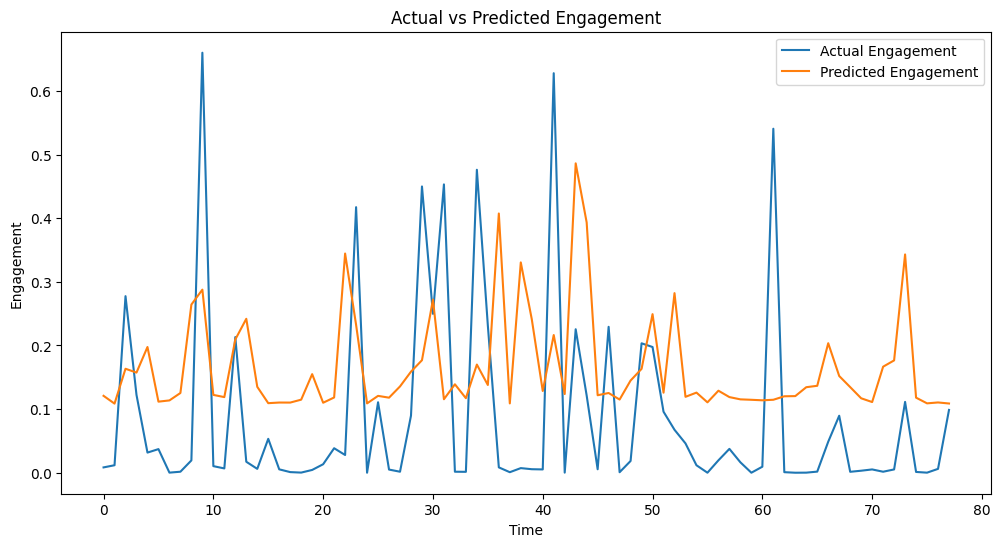

In [34]:
# Visualize predictions vs actual values
plt.figure(figsize=(12, 6))
plt.plot(test_target, label='Actual Engagement')
plt.plot(test_preds, label='Predicted Engagement')
plt.title('Actual vs Predicted Engagement')
plt.xlabel('Time')
plt.ylabel('Engagement')
plt.legend()
plt.show()

In [36]:
model.eval()

LSTMModel(
  (lstm): LSTM(1, 512, num_layers=2, dropout=0.2)
  (linear): Linear(in_features=512, out_features=1, bias=True)
)

## Saved Model

In [35]:
state_dict = model.state_dict()

torch.save(state_dict, 'model.pth')